### Analysis of Graduate Admission using Deep Learning

I utilised tensorflow/keras to build a neural network model to predict the admission rate of Masters Programs based on students' undergraduate performance. The following analysis involves data cleaning, data analysis and data visualisation.

#### 1) Initilisation and Data Cleaning

Loading the necessary packages from the virtual environment setup.

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import randint as sp_randint

In [132]:
# Reading admissions dataset and viewing the first few rows
dataset=pd.read_csv('admissions_data.csv')
dataset.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [133]:
# Dropping serial number as it has no influence on our prediction
dataset.drop('Serial No.', axis=1, inplace=True)

In [134]:
# Extracting feature values and labels(last column includes admission percentage)
features=dataset.iloc[:,0:-1]
labels=dataset.iloc[:,-1]

In [135]:
# Creating training and testing sets
# test_size set at 0.30 as a modest split for evaluation of model;
# random_state set to an int for easily-reproducible results
features_train,features_test,labels_train,labels_test=train_test_split(
features,labels,test_size=0.30,random_state=1)

In [136]:
# Performing standardisation to scale all numeric feature values
sc=StandardScaler()
features_train_scale=sc.fit_transform(features_train)
features_test_scale=sc.transform(features_test)
features_train_scale=pd.DataFrame(features_train_scale,columns=features_train.columns)
features_test_scale=pd.DataFrame(features_test_scale,columns=features_test.columns)

#### 2) Creating model

Creating a separate design_model() function that involves adding layers to the ANN model.

In [170]:
# Number of input features that form the number of input nodes 
# Used to construct the model in the next step
features_train_scale.shape[1]

7

In [172]:
# Defining model
# Options: number of hidden layers, number of nodes per layer, activation functions
        # type of optimisation function, loss function, evaluation metrics
# Given a linear regression problem, loss function=mean squared error and
# evaluation metrix=mean absolute error
def design_model():
    model=Sequential()
    inputL=InputLayer(input_shape=(7,))
    model.add(inputL)
    model.add(Dense(16,activation='relu')) #relu activation function for linear regression
    #------Alternatives------
    #model.add(layers.Dropout(0.1)) 
    #model.add(Dense(16,activation='relu'))
    #model.add(layers.Dropout(0.1))
    #------Alternatives------
    model.add(Dense(1))
    opt=Adam(learning_rate=0.001) # Choosing the Adam optimizer as a starter
    model.compile(loss='mse',metrics=['mae'],optimizer=opt)
    return model

#### 3) Tuning Hyperparameters (Batch size and epochs)

Automatically tuning the hyperparameters using a grid search method and a randomised search method and comparing the results. Grid search requires picking specific values to test. This is rather arbitary but we follow the usual convention of doubling each trial value and limiting to 9 chooses. Randomised search picks integer value given a range. The number of iterations picked is larger to test if it converges towards the grid search method to show a general trend.

#### Grid Search Method (batch size and epochs)

In [179]:
# Carrying out grid search to optimise batch-size and epochs
batch_size=[2,4,8]
epochs=[20,40,80]
model=KerasRegressor(build_fn=design_model)
param_grid=dict(batch_size=batch_size, epochs=epochs)
grid=GridSearchCV(estimator=model, param_grid=param_grid,
                  scoring=make_scorer(mean_squared_error, greater_is_better=False),
                  return_train_score=True)
grid_result_grid=grid.fit(features_train_scale, labels_train, verbose=0)
print(grid_result_grid)

GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002850DC60648>,
             param_grid={'batch_size': [2, 4, 8], 'epochs': [20, 40, 80]},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))


In [180]:
print("Results from grid search show that")
print("Best: %f using %s" % (grid_result_grid.best_score_, grid_result_grid.best_params_))

Results from grid search show that
Best: -0.005305 using {'batch_size': 2, 'epochs': 80}


#### Randomized Search Method (batch size and epochs)

In [193]:
# Carrying out randomised search to optimse batch-size and epochs
param_grid={'batch_size':randint(2,8),'nb_epoch':randint(20,80)}
model=KerasRegressor(build_fn=design_model)
grid=RandomizedSearchCV(estimator=model,param_distributions=param_grid,
                        scoring=make_scorer(mean_squared_error,greater_is_better=False), 
                        n_iter=50)
grid_result_random=grid.fit(features_train_scale,labels_train,verbose=0)
print(grid_result_random)

RandomizedSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002854BEFAD88>,
                   n_iter=50,
                   param_distributions={'batch_size': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002854BEFA8C8>,
                                        'nb_epoch': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002854BEFAEC8>},
                   scoring=make_scorer(mean_squared_error, greater_is_better=False))


In [194]:
print("Results from randomised search show that")
print("Best: %f using %s" % (grid_result_random.best_score_, grid_result_random.best_params_))

Results from randomised search show that
Best: -0.143152 using {'batch_size': 2, 'nb_epoch': 50}


Given a relatively small randomised range for the batch size, randomised search has concluded the same result as grid search giving a batch size of 2. The number of epochs obtained (50 in our run) is quite far off from the grid search result given the randomness of the search. To get a more coherent solution, one could increase the number of iterations randomised search operates on but that would demand more computaion which defeats the purpose of randomised search.

The result from grid search [batch_size:2, epochs:80] seems to suggest more epochs is better. However, this does not mean a threshold of 80 is the upper bound number of epochs necessary. Perhaps adding even more epochs would reduce costs significantly. This could be explored with early stopping next.

#### 4) Tuning Hyperparameters (Early stopping)

Too small a patience level for the early stopping function could be vulnerable to error fluctuation associated with a large learning rate or too small a batch size (both could lead to large jumps of the cost function). On the safe side, choosing a larger patience ensures more confidence in observing that cost is monotonically decreasing. 

We start with a large patience value of 50 epochs and observe the learning curves.

#### Patience level=50; Batch size: 2; Epochs: 80

In [211]:
# Using early stopping to save computaion time
es=EarlyStopping(monitor='val_loss',mode='min',verbose=0,patience=50)

# Creating and training model
my_model=design_model()
results=my_model.fit(features_train_scale, labels_train, 
                     epochs=80, batch_size=2, verbose=1, validation_split=0.25,
                     callbacks=[es])

# Evaluating mse(loss), mae and R2 metrics of the model
val_mse,val_mae=my_model.evaluate(features_test_scale,labels_test,verbose=0)
y_pred=my_model.predict(features_test_scale)
print('Final MAE metric:',val_mae)
print('R2 metric:',r2_score(labels_test,y_pred))

Train on 262 samples, validate on 88 samples
Epoch 1/80
262/262 [==============================] - 1s 2ms/sample - loss: 0.2211 - mae: 0.3855 - val_loss: 0.1214 - val_mae: 0.2842
Epoch 2/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0999 - mae: 0.2461 - val_loss: 0.0611 - val_mae: 0.1952
Epoch 3/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0595 - mae: 0.1895 - val_loss: 0.0351 - val_mae: 0.1414
Epoch 4/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0402 - mae: 0.1545 - val_loss: 0.0255 - val_mae: 0.1187
Epoch 5/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0307 - mae: 0.1360 - val_loss: 0.0192 - val_mae: 0.1026
Epoch 6/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0246 - mae: 0.1236 - val_loss: 0.0158 - val_mae: 0.0956
Epoch 7/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0204 - mae: 0.1124 - val_loss: 0.0142 - val_mae: 0.0886
Epoch 8/80
262/26

262/262 [==============================] - 0s 1ms/sample - loss: 0.0037 - mae: 0.0456 - val_loss: 0.0043 - val_mae: 0.0484
Epoch 62/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0036 - mae: 0.0460 - val_loss: 0.0048 - val_mae: 0.0517
Epoch 63/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0035 - mae: 0.0440 - val_loss: 0.0041 - val_mae: 0.0477
Epoch 64/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0036 - mae: 0.0448 - val_loss: 0.0046 - val_mae: 0.0515
Epoch 65/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0033 - mae: 0.0440 - val_loss: 0.0050 - val_mae: 0.0529
Epoch 66/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0037 - mae: 0.0451 - val_loss: 0.0042 - val_mae: 0.0491
Epoch 67/80
262/262 [==============================] - 0s 1ms/sample - loss: 0.0034 - mae: 0.0429 - val_loss: 0.0044 - val_mae: 0.0494
Epoch 68/80
262/262 [==============================] - 0s 1ms/sampl

patience level=50


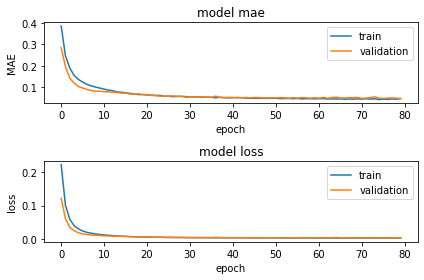

In [212]:
# Plotting MAE and loss metrics against epochs
print("patience level=50")
fig=plt.figure()
ax1=fig.add_subplot(2, 1, 1)
ax1.plot(results.history['mae'])
ax1.plot(results.history['val_mae'])
ax1.set_title('model mae')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper right')

ax2=fig.add_subplot(2, 1, 2)
ax2.plot(results.history['loss'])
ax2.plot(results.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper right')

plt.tight_layout()
plt.show()

Learning curve seems to have spanned the entire 80 epochs meaning the model is not terminated earlier. This could mean our patience value is too large or model still has room for improvement with lower losses. However as shown with the curves, the MAE score and loss function only seem to have drastic decrease in the early iterations. Epochs after around 30 seem to be giving diminishin marginal returns. Hence, we could try to reduce the patience level while increasing number of epochs observe results.

#### Patience level:30; Batch size:2; Epochs:100

In [213]:
# Using early stopping to save computaion time
es=EarlyStopping(monitor='val_loss',mode='min',verbose=0,patience=30)
my_model=design_model()
results=my_model.fit(features_train_scale, labels_train, 
                     epochs=100, batch_size=2, verbose=1, validation_split=0.25,
                     callbacks=[es])
val_mse,val_mae=my_model.evaluate(features_test_scale,labels_test,verbose=0)
y_pred=my_model.predict(features_test_scale)
print('Final MAE metric:',val_mae)
print('R2 metric:',r2_score(labels_test,y_pred))

Train on 262 samples, validate on 88 samples
Epoch 1/100
262/262 [==============================] - 1s 3ms/sample - loss: 0.3055 - mae: 0.4585 - val_loss: 0.1563 - val_mae: 0.3268
Epoch 2/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0912 - mae: 0.2485 - val_loss: 0.0868 - val_mae: 0.2405
Epoch 3/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0507 - mae: 0.1836 - val_loss: 0.0571 - val_mae: 0.1934
Epoch 4/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0325 - mae: 0.1450 - val_loss: 0.0409 - val_mae: 0.1617
Epoch 5/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0225 - mae: 0.1198 - val_loss: 0.0306 - val_mae: 0.1376
Epoch 6/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0168 - mae: 0.1036 - val_loss: 0.0239 - val_mae: 0.1195
Epoch 7/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0132 - mae: 0.0926 - val_loss: 0.0197 - val_mae: 0.1071
Epoch 8/10

Epoch 61/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0031 - mae: 0.0407 - val_loss: 0.0035 - val_mae: 0.0424
Epoch 62/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0034 - mae: 0.0423 - val_loss: 0.0033 - val_mae: 0.0417
Epoch 63/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0032 - mae: 0.0416 - val_loss: 0.0037 - val_mae: 0.0440
Epoch 64/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0034 - mae: 0.0437 - val_loss: 0.0036 - val_mae: 0.0439
Epoch 65/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0030 - mae: 0.0401 - val_loss: 0.0037 - val_mae: 0.0458
Epoch 66/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0032 - mae: 0.0415 - val_loss: 0.0034 - val_mae: 0.0427
Epoch 67/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0032 - mae: 0.0423 - val_loss: 0.0037 - val_mae: 0.0464
Epoch 68/100
262/262 [==========================

patience level=30


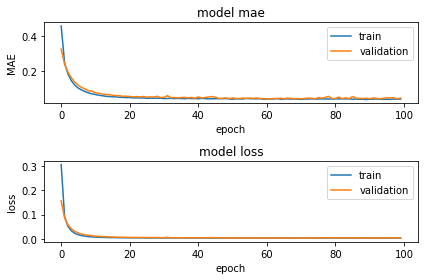

In [214]:
# Plotting MAE and loss metrics against epochs
print("patience level=30")
fig=plt.figure()
ax1=fig.add_subplot(2, 1, 1)
ax1.plot(results.history['mae'])
ax1.plot(results.history['val_mae'])
ax1.set_title('model mae')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper right')

ax2=fig.add_subplot(2, 1, 2)
ax2.plot(results.history['loss'])
ax2.plot(results.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper right')

plt.tight_layout()
plt.show()

Again, early stopping is not triggered. Perhaps we could reduce patience value even more. However, we could observe the noise associated with the MAE curves. This is a sign of instability that is associated with low batch size. If we increase the batch size, each optimisation could better follow a downward trend of the loss function. Though this may contradict with our best_param obtained using grid search, the earlier analysis was only an initial guess of the best paramaters. We could manually fine-tune the model more now.

Good news is that loss function has reduced even more and the coeffecient of determination has increased showing increasing epochs leads to a lower loss function.

#### Patience level:5; Batch size:4; Epochs: 100

In [221]:
# Using early stopping to save computaion time
es=EarlyStopping(monitor='val_loss',mode='min',verbose=0,patience=5)
my_model=design_model()
results=my_model.fit(features_train_scale, labels_train, 
                     epochs=100, batch_size=4, verbose=1, validation_split=0.25,
                     callbacks=[es])
val_mse,val_mae=my_model.evaluate(features_test_scale,labels_test,verbose=0)
y_pred=my_model.predict(features_test_scale)
print('Final MAE metric:',val_mae)
print('R2 metric:',r2_score(labels_test,y_pred))

Train on 262 samples, validate on 88 samples
Epoch 1/100
262/262 [==============================] - 1s 2ms/sample - loss: 0.2578 - mae: 0.4357 - val_loss: 0.1661 - val_mae: 0.3226
Epoch 2/100
262/262 [==============================] - 0s 788us/sample - loss: 0.1160 - mae: 0.2766 - val_loss: 0.1024 - val_mae: 0.2513
Epoch 3/100
262/262 [==============================] - 0s 808us/sample - loss: 0.0767 - mae: 0.2191 - val_loss: 0.0789 - val_mae: 0.2218
Epoch 4/100
262/262 [==============================] - 0s 815us/sample - loss: 0.0585 - mae: 0.1924 - val_loss: 0.0595 - val_mae: 0.1904
Epoch 5/100
262/262 [==============================] - 0s 799us/sample - loss: 0.0479 - mae: 0.1737 - val_loss: 0.0496 - val_mae: 0.1763
Epoch 6/100
262/262 [==============================] - 0s 808us/sample - loss: 0.0383 - mae: 0.1555 - val_loss: 0.0415 - val_mae: 0.1632
Epoch 7/100
262/262 [==============================] - 0s 794us/sample - loss: 0.0318 - mae: 0.1405 - val_loss: 0.0366 - val_mae: 0.155

262/262 [==============================] - 0s 744us/sample - loss: 0.0035 - mae: 0.0446 - val_loss: 0.0052 - val_mae: 0.0556
Epoch 61/100
262/262 [==============================] - 0s 734us/sample - loss: 0.0036 - mae: 0.0442 - val_loss: 0.0050 - val_mae: 0.0537
Epoch 62/100
262/262 [==============================] - 0s 729us/sample - loss: 0.0038 - mae: 0.0463 - val_loss: 0.0046 - val_mae: 0.0494
Epoch 63/100
262/262 [==============================] - 0s 763us/sample - loss: 0.0037 - mae: 0.0460 - val_loss: 0.0047 - val_mae: 0.0500
Epoch 64/100
262/262 [==============================] - 0s 774us/sample - loss: 0.0037 - mae: 0.0472 - val_loss: 0.0051 - val_mae: 0.0525
Epoch 65/100
262/262 [==============================] - 0s 758us/sample - loss: 0.0040 - mae: 0.0466 - val_loss: 0.0046 - val_mae: 0.0497
Epoch 66/100
262/262 [==============================] - 0s 763us/sample - loss: 0.0034 - mae: 0.0433 - val_loss: 0.0046 - val_mae: 0.0500
Epoch 67/100
262/262 [=========================

patience level=5


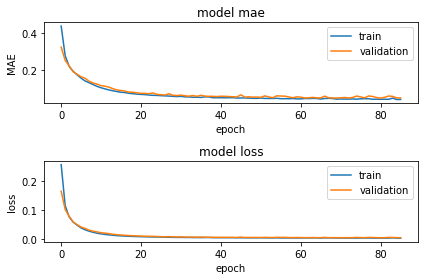

In [223]:
# Plotting MAE and loss metrics against epochs
print("patience level=5")
fig=plt.figure()
ax1=fig.add_subplot(2, 1, 1)
ax1.plot(results.history['mae'])
ax1.plot(results.history['val_mae'])
ax1.set_title('model mae')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper right')

ax2=fig.add_subplot(2, 1, 2)
ax2.plot(results.history['loss'])
ax2.plot(results.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper right')

plt.tight_layout()
plt.show()

Early stopping is triggered at last but lowering the patience level to 5 seems to have worsened our result. Given the number of epochs of 100,  introducing a reasonable early stopping is rather futile. As 100 epochs is not an extremely large number worth reducing at the same time a patience level of 5 is rather pointless, we might as well just leave the model as 100 epochs with no early stopping. The MAE metric and R2 metric show pretty good performance anyway.

#### 5) Adjusting models

Attempting to adjust the model architecture to see if results would be better. Available options are to add more layers or neurons per layer to see if a better fit to the data is available. 

#### Extra hidden layer of 16 neurons

In [229]:
# Adjusting model architecture
def design_model_v2():
    model=Sequential()
    inputL=InputLayer(input_shape=(7,))
    model.add(inputL)
    model.add(Dense(16,activation='relu')) #relu activation function for linear regression
    model.add(Dense(16,activation='relu')) #extra layer of neurons
    #------Alternatives------
    #model.add(layers.Dropout(0.1)) 
    #model.add(Dense(16,activation='relu'))
    #model.add(layers.Dropout(0.1))
    #------Alternatives------
    model.add(Dense(1))
    opt=Adam(learning_rate=0.001) # Choosing the Adam optimizer as a starter
    model.compile(loss='mse',metrics=['mae'],optimizer=opt)
    return model

In [230]:
# Testing new model layout
my_model=design_model_v2()
results=my_model.fit(features_train_scale, labels_train, 
                     epochs=100, batch_size=4, verbose=1, validation_split=0.25,)
val_mse,val_mae=my_model.evaluate(features_test_scale,labels_test,verbose=0)
y_pred=my_model.predict(features_test_scale)
print('Final MAE metric:',val_mae)
print('R2 metric:',r2_score(labels_test,y_pred))

Train on 262 samples, validate on 88 samples
Epoch 1/100
262/262 [==============================] - 1s 2ms/sample - loss: 0.3679 - mae: 0.5350 - val_loss: 0.1254 - val_mae: 0.3085
Epoch 2/100
262/262 [==============================] - 0s 946us/sample - loss: 0.0687 - mae: 0.2065 - val_loss: 0.0439 - val_mae: 0.1703
Epoch 3/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0338 - mae: 0.1429 - val_loss: 0.0279 - val_mae: 0.1333
Epoch 4/100
262/262 [==============================] - 0s 845us/sample - loss: 0.0223 - mae: 0.1157 - val_loss: 0.0205 - val_mae: 0.1133
Epoch 5/100
262/262 [==============================] - 0s 917us/sample - loss: 0.0165 - mae: 0.0991 - val_loss: 0.0159 - val_mae: 0.0991
Epoch 6/100
262/262 [==============================] - 0s 849us/sample - loss: 0.0127 - mae: 0.0871 - val_loss: 0.0128 - val_mae: 0.0883
Epoch 7/100
262/262 [==============================] - 0s 877us/sample - loss: 0.0103 - mae: 0.0780 - val_loss: 0.0117 - val_mae: 0.0839


262/262 [==============================] - 0s 820us/sample - loss: 0.0028 - mae: 0.0386 - val_loss: 0.0059 - val_mae: 0.0564
Epoch 61/100
262/262 [==============================] - 0s 780us/sample - loss: 0.0026 - mae: 0.0378 - val_loss: 0.0058 - val_mae: 0.0541
Epoch 62/100
262/262 [==============================] - 0s 826us/sample - loss: 0.0026 - mae: 0.0375 - val_loss: 0.0058 - val_mae: 0.0556
Epoch 63/100
262/262 [==============================] - 0s 802us/sample - loss: 0.0025 - mae: 0.0368 - val_loss: 0.0058 - val_mae: 0.0543
Epoch 64/100
262/262 [==============================] - 0s 791us/sample - loss: 0.0026 - mae: 0.0369 - val_loss: 0.0057 - val_mae: 0.0544
Epoch 65/100
262/262 [==============================] - 0s 888us/sample - loss: 0.0024 - mae: 0.0362 - val_loss: 0.0059 - val_mae: 0.0557
Epoch 66/100
262/262 [==============================] - 0s 833us/sample - loss: 0.0026 - mae: 0.0387 - val_loss: 0.0064 - val_mae: 0.0592
Epoch 67/100
262/262 [=========================

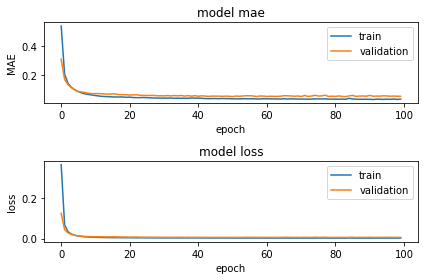

In [231]:
# Plotting MAE and loss metrics against epochs
fig=plt.figure()
ax1=fig.add_subplot(2, 1, 1)
ax1.plot(results.history['mae'])
ax1.plot(results.history['val_mae'])
ax1.set_title('model mae')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper right')

ax2=fig.add_subplot(2, 1, 2)
ax2.plot(results.history['loss'])
ax2.plot(results.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper right')

plt.tight_layout()
plt.show()

Adding an extra layer has led to high variance issue where our model has overfitted the training the dataset. This led to a higher loss function associated with the cross validation set as opposed to the training dataset. We could adjust this by chaning the cross validation split or introducing regularisation terms such as drop outs.

#### Adding in drop out layers

In [241]:
# Adjusting model architecture
def design_model_v3():
    model=Sequential()
    inputL=InputLayer(input_shape=(7,))
    model.add(inputL)
    model.add(Dense(16,activation='relu')) #relu activation function for linear regression
    model.add(layers.Dropout(0.1)) 
    model.add(Dense(16,activation='relu'))
    model.add(layers.Dropout(0.1))
    #------Alternatives------
    #model.add(layers.Dropout(0.1)) 
    #model.add(Dense(16,activation='relu'))
    #model.add(layers.Dropout(0.1))
    #------Alternatives------
    model.add(Dense(1))
    opt=Adam(learning_rate=0.001) # Choosing the Adam optimizer as a starter
    model.compile(loss='mse',metrics=['mae'],optimizer=opt)
    return model

In [242]:
# Testing new model layout
my_model=design_model_v3()
results=my_model.fit(features_train_scale, labels_train, 
                     epochs=100, batch_size=4, verbose=1, validation_split=0.25,)
val_mse,val_mae=my_model.evaluate(features_test_scale,labels_test,verbose=0)
y_pred=my_model.predict(features_test_scale)
print('Final MAE metric:',val_mae)
print('R2 metric:',r2_score(labels_test,y_pred))

Train on 262 samples, validate on 88 samples
Epoch 1/100
262/262 [==============================] - 1s 3ms/sample - loss: 0.1934 - mae: 0.3608 - val_loss: 0.0710 - val_mae: 0.2253
Epoch 2/100
262/262 [==============================] - 0s 842us/sample - loss: 0.0859 - mae: 0.2335 - val_loss: 0.0367 - val_mae: 0.1532
Epoch 3/100
262/262 [==============================] - 0s 852us/sample - loss: 0.0662 - mae: 0.2059 - val_loss: 0.0276 - val_mae: 0.1334
Epoch 4/100
262/262 [==============================] - 0s 824us/sample - loss: 0.0512 - mae: 0.1759 - val_loss: 0.0229 - val_mae: 0.1218
Epoch 5/100
262/262 [==============================] - 0s 826us/sample - loss: 0.0411 - mae: 0.1631 - val_loss: 0.0181 - val_mae: 0.1084
Epoch 6/100
262/262 [==============================] - 0s 826us/sample - loss: 0.0334 - mae: 0.1476 - val_loss: 0.0160 - val_mae: 0.1036
Epoch 7/100
262/262 [==============================] - 0s 1ms/sample - loss: 0.0392 - mae: 0.1528 - val_loss: 0.0133 - val_mae: 0.0902


262/262 [==============================] - 0s 856us/sample - loss: 0.0053 - mae: 0.0554 - val_loss: 0.0041 - val_mae: 0.0502
Epoch 61/100
262/262 [==============================] - 0s 826us/sample - loss: 0.0055 - mae: 0.0583 - val_loss: 0.0038 - val_mae: 0.0465
Epoch 62/100
262/262 [==============================] - 0s 811us/sample - loss: 0.0047 - mae: 0.0521 - val_loss: 0.0038 - val_mae: 0.0470
Epoch 63/100
262/262 [==============================] - 0s 826us/sample - loss: 0.0046 - mae: 0.0521 - val_loss: 0.0038 - val_mae: 0.0477
Epoch 64/100
262/262 [==============================] - 0s 807us/sample - loss: 0.0046 - mae: 0.0517 - val_loss: 0.0036 - val_mae: 0.0448
Epoch 65/100
262/262 [==============================] - 0s 881us/sample - loss: 0.0047 - mae: 0.0523 - val_loss: 0.0036 - val_mae: 0.0449
Epoch 66/100
262/262 [==============================] - 0s 841us/sample - loss: 0.0044 - mae: 0.0501 - val_loss: 0.0035 - val_mae: 0.0437
Epoch 67/100
262/262 [=========================

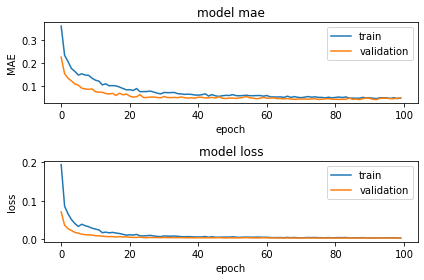

In [243]:
# Plotting MAE and loss metrics against epochs
fig=plt.figure()
ax1=fig.add_subplot(2, 1, 1)
ax1.plot(results.history['mae'])
ax1.plot(results.history['val_mae'])
ax1.set_title('model mae')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper right')

ax2=fig.add_subplot(2, 1, 2)
ax2.plot(results.history['loss'])
ax2.plot(results.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper right')

plt.tight_layout()
plt.show()

Adding drop out layers clearly solved the issue of overfitting. The noise with the learning curves however remain an issue. This could be addressed with more fine-tuning of the learning rate or the optimsation strategy. This could involve a lot more work and time. For the purpose of our analysis, our final model has achieved relatively good results with a coefficient of determination of 0.8066. 

#### 6) Future work

Future imporvements of the model could entail tuning of all the hyperparameters in one single grid search/ randomised search method that will guarantee the best result. More attention on data volume and data quality could lead to more accurate models as well. Due to the limited amount of computing power on my personal laptop, this has been an interesting analysis to look at.